In [2]:
%load_ext autoreload
%autoreload 2
import glob
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import sys
sys.path.append("..")
from dnn.ak_sample_loader import *
from dnn.torch_dataset import *
from dnn.training import *
from dnn.validation import *

In [3]:
device="cuda:0"
feature_version = "feat-v2"

In [21]:
input = AkSampleLoader.loadFromPickle(f"/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_PU/v1/100_assoc.pkl")

In [22]:
input.makeDataAk()

ValueError: cannot broadcast nested list

In [4]:
# input_histo_path = "root://eosuser.cern.ch//eos/user/a/aperego/SampleProduction/ParticleGunPionPU200_v5/histo_200PU_v5_new.root" # Aurora's 200PU pions (1k events)
energies_PU = [10, 20, 50, 100, 200, 500]
inputs = {energy : AkSampleLoader.loadFromPickle(f"/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_PU/v1/{energy}.pkl") for energy in energies_PU}
datasets = {energy : RegressionDataset(input, feature_version, device=device) for energy, input in inputs.items()}

In [19]:
inputs = {energy : AkSampleLoader.loadFromPickle(f"/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_PU/v1/{energy}.pkl") for energy in energies_PU}

In [20]:
for i, input in enumerate(inputs.values()):
    print(i)
    input.selectPUAssociated()

0
1
2
3
4
5


In [17]:
inputs[100].selectPUAssociated()

IndexError: cannot slice ListArray (of length 500) with [[2092], [3441], [2230], [3505], [], ..., [1962], [3539], [2054, 3710], [2110]]: index out of range while attempting to get index 2092 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-29/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [15]:
inputs[10].tracksters_splitEndcaps.raw_energy

<Array [[2.04, 7.04, 1.65, ..., 2, 3.12], ...] type='500 * var * float32'>

In [4]:
from dnn.model import *
model_path = "/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v9/largeDNN-ratioLoss-constrained/model.pt"
model = LargeDNN(len(features["feat-v2"]))

getResultsFromModel=getResultsFromModel_basicLoss

In [5]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model.to(device)

LargeDNN(
  (model): Sequential(
    (0): Linear(in_features=17, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): ReLU()
    (8): Linear(in_features=40, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=10, bias=True)
    (13): ReLU()
    (14): Linear(in_features=10, out_features=5, bias=True)
    (15): ReLU()
    (16): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [17]:
energy = 20
assoc_threshold = 0.8
pred_loader = makeDataLoader(datasets[energy], batch_size=200000)

pred_trackster_energies, pred_full_energy = getResultsFromModel(model, next(iter(pred_loader)))
predForAssociatedTracksters = netPredictionsForCPAssociatedTracksters(inputs[energy], pred_trackster_energies, assoc_threshold)
rawEnergyForAssociatedTracksters = rawEnergySumForCPAssociatedTracksters(inputs[energy], "raw_energy", assoc_threshold)

hists = createHists()
fillHists(hists, datasets[energy].cp_energy, pred_trackster_energies=pred_trackster_energies, pred_full_energy=predForAssociatedTracksters,
          raw_energy=ak.flatten(inputs[energy].tracksters_splitEndcaps.raw_energy), raw_full_energy=rawEnergyForAssociatedTracksters,
          cnn_energy=ak.flatten(inputs[energy].tracksters_splitEndcaps.regressed_energy), cnn_full_energy=rawEnergySumForCPAssociatedTracksters(inputs[energy], "regressed_energy", assoc_threshold))
hists

{'h_pred': Hist(Regular(200, 0, 100, name='pred_energy', label='fastDNN Predicted trackster energy (GeV)'), storage=Double()) # Sum: 1386251.0 (1968471.0 with flow),
 'h_reco': Hist(Regular(200, 0, 100, name='reco_energy', label='Trackster raw energy (GeV)'), storage=Double()) # Sum: 1968438.0 (1968471.0 with flow),
 'h_cnn': Hist(Regular(200, 0, 100, name='cnn_energy', label='Trackster regressed energy (Kate CNN) (GeV)'), storage=Double()) # Sum: 1968432.0 (1968471.0 with flow),
 'h_pred_vs_reco': Hist(
   Regular(200, 0, 100, name='reco_energy', label='Trackster raw energy (GeV)'),
   Regular(200, 0, 100, name='pred_energy', label='Predicted trackster energy (GeV)'),
   storage=Double()) # Sum: 1386239.0 (1968471.0 with flow),
 'h_pred_vs_reco_vs_cnn': Hist(
   Regular(200, 0, 100, name='reco_energy', label='Trackster raw energy (GeV)'),
   Regular(200, 0, 100, name='pred_energy', label='fastDNN trackster energy (GeV)'),
   Regular(200, 0, 100, name='cnn_energy', label='CNN Trackster

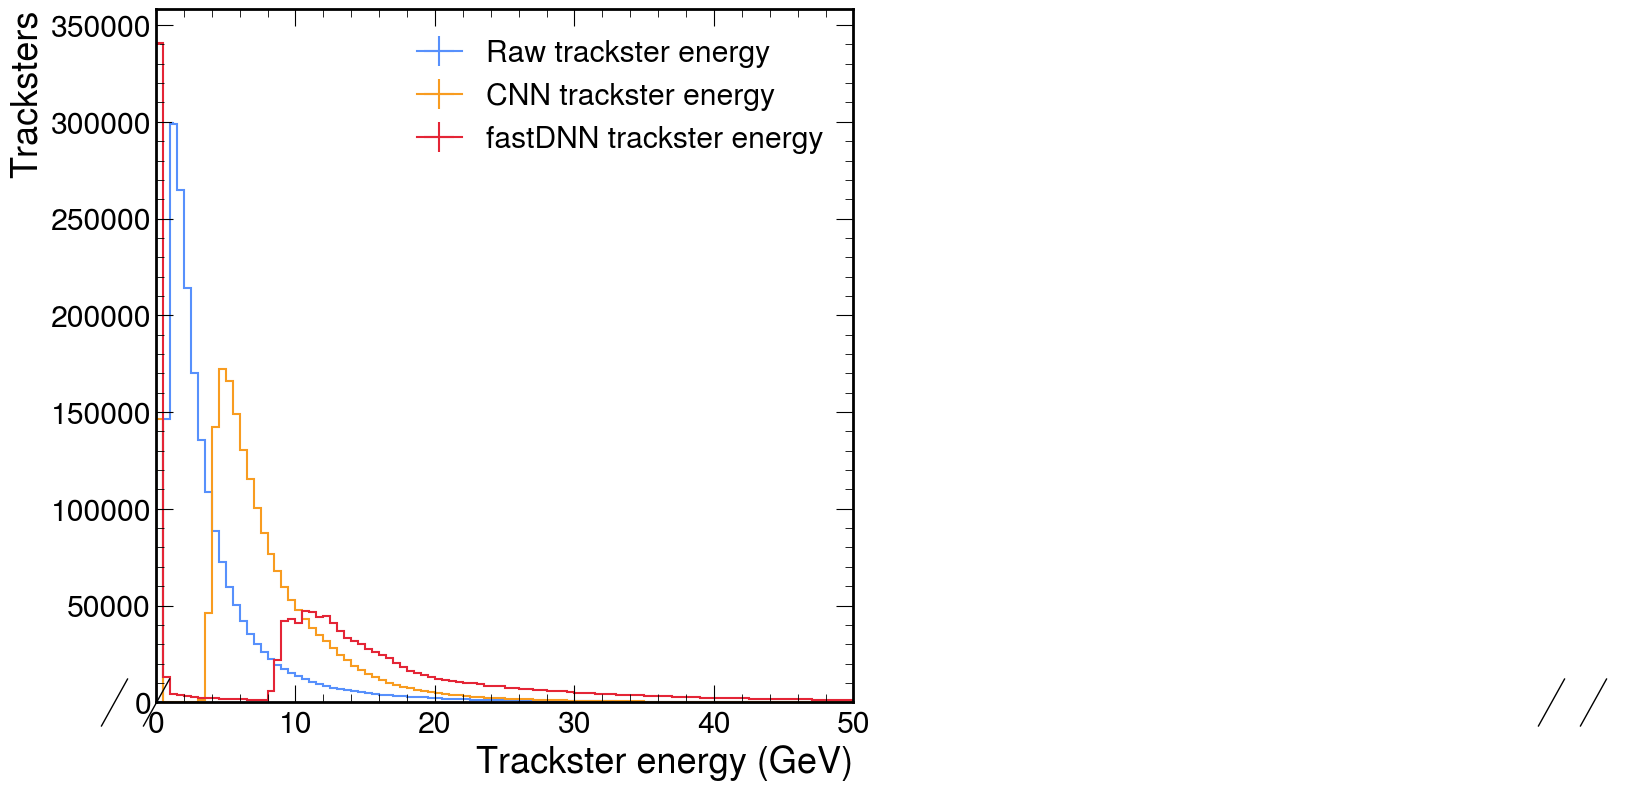

In [18]:
plotTracksterEnergies(hists)

(0.0, 50.0)

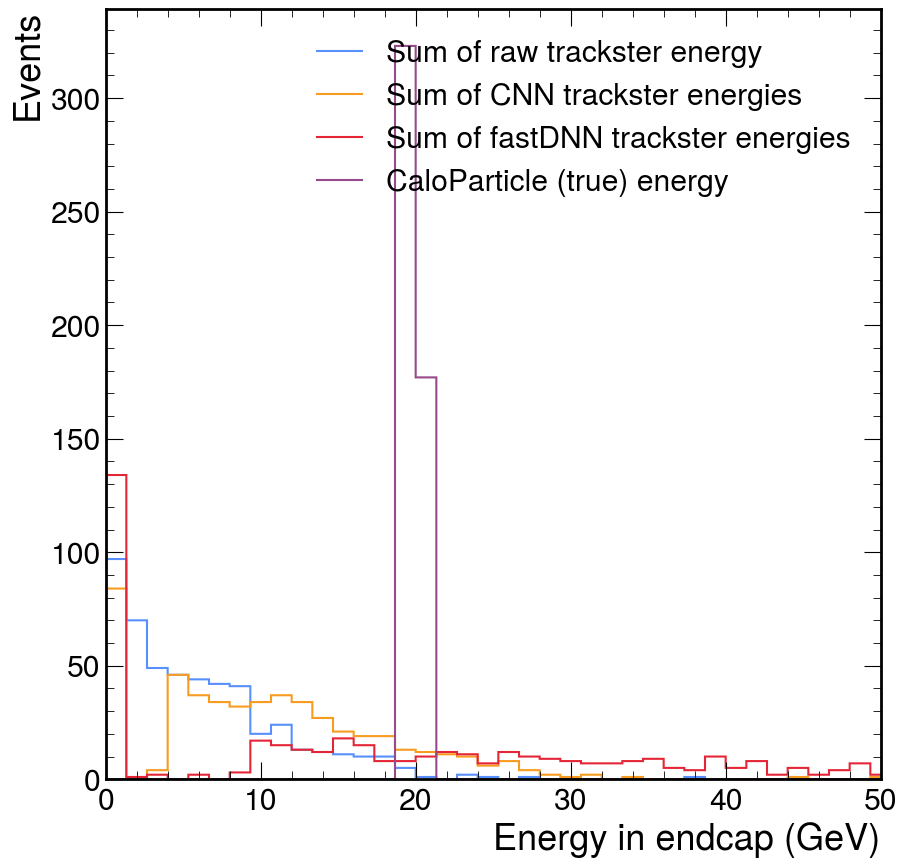

In [19]:
plotFullEnergies(hists)
plt.xlim(0, 50)

In [23]:
doFullValidation_PU("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v9/largeDNN-ratioLoss-constrained/", model, inputs, datasets)

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: di

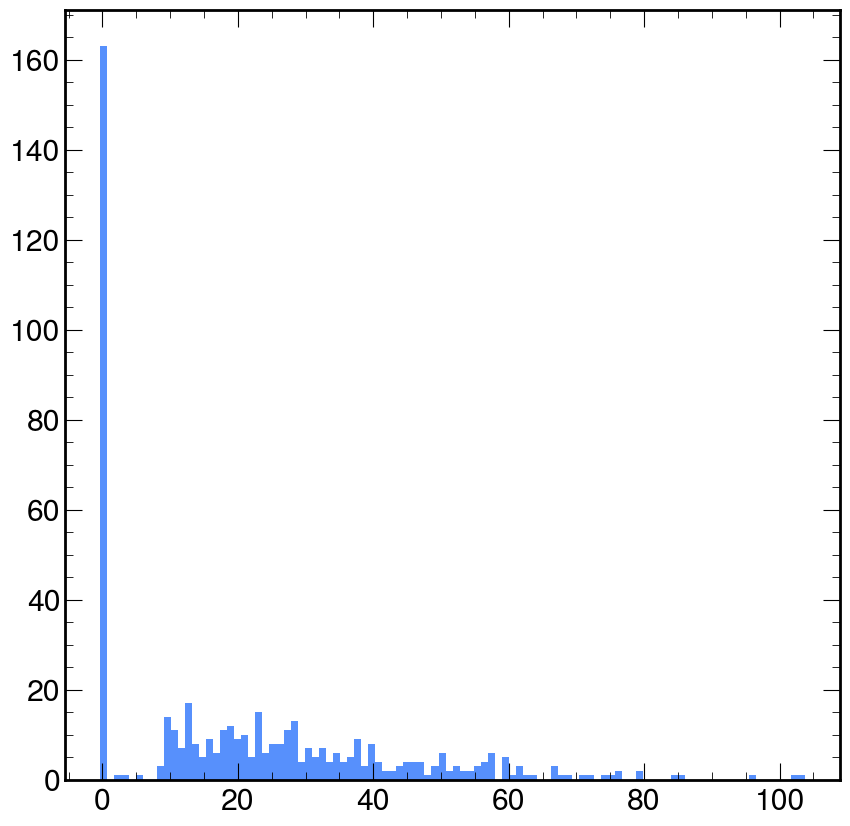

In [ ]:
plt.hist(sumPrediction_results[10], bins=100)
None

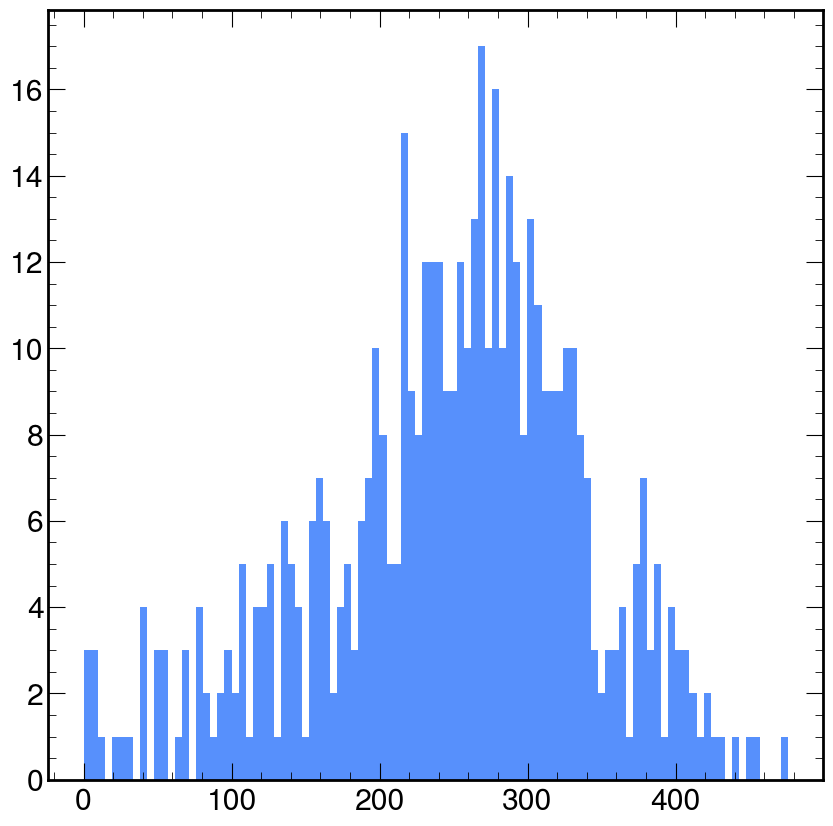

In [ ]:
plt.hist(rawEnergySumForCPAssociatedTracksters(inputs[500], 0.9), bins=100)
None

In [ ]:
feats = RegressionDataset(input, feature_version).features
feats

<Array [[[40.1, -2.89, ..., 0, 0], ...], ...] type='20 * var * 17 * float64'>

In [ ]:
features

{'feat-v1': {0: 'raw_energy',
  1: 'barycenter_eta',
  2: 'barycenter_z',
  3: 'energy_CE_E_120',
  4: 'energy_CE_E_200',
  5: 'energy_CE_E_300',
  6: 'energy_CE_H_120',
  7: 'energy_CE_H_200',
  8: 'energy_CE_H_300',
  9: 'energy_CE_H_SCINT'},
 'feat-v1-cellTypeOnly': {0: 'energy_CE_E_120',
  1: 'energy_CE_E_200',
  2: 'energy_CE_E_300',
  3: 'energy_CE_H_120',
  4: 'energy_CE_H_200',
  5: 'energy_CE_H_300',
  6: 'energy_CE_H_SCINT'},
 'feat-v2': {0: 'raw_energy',
  1: 'barycenter_eta',
  2: 'barycenter_z',
  3: 'EV1',
  4: 'EV2',
  5: 'EV3',
  6: 'sigmaPCA1',
  7: 'sigmaPCA2',
  8: 'sigmaPCA3',
  9: 'NClusters',
  10: 'energy_CE_E_120',
  11: 'energy_CE_E_200',
  12: 'energy_CE_E_300',
  13: 'energy_CE_H_120',
  14: 'energy_CE_H_200',
  15: 'energy_CE_H_300',
  16: 'energy_CE_H_SCINT'}}

(array([5.6162e+04, 1.6175e+04, 5.8740e+03, 2.1240e+03, 6.8200e+02,
        2.0800e+02, 7.1000e+01, 1.4000e+01, 4.0000e+00, 2.0000e+00]),
 array([  2. ,  16.1,  30.2,  44.3,  58.4,  72.5,  86.6, 100.7, 114.8,
        128.9, 143. ]),
 <BarContainer object of 10 artists>)

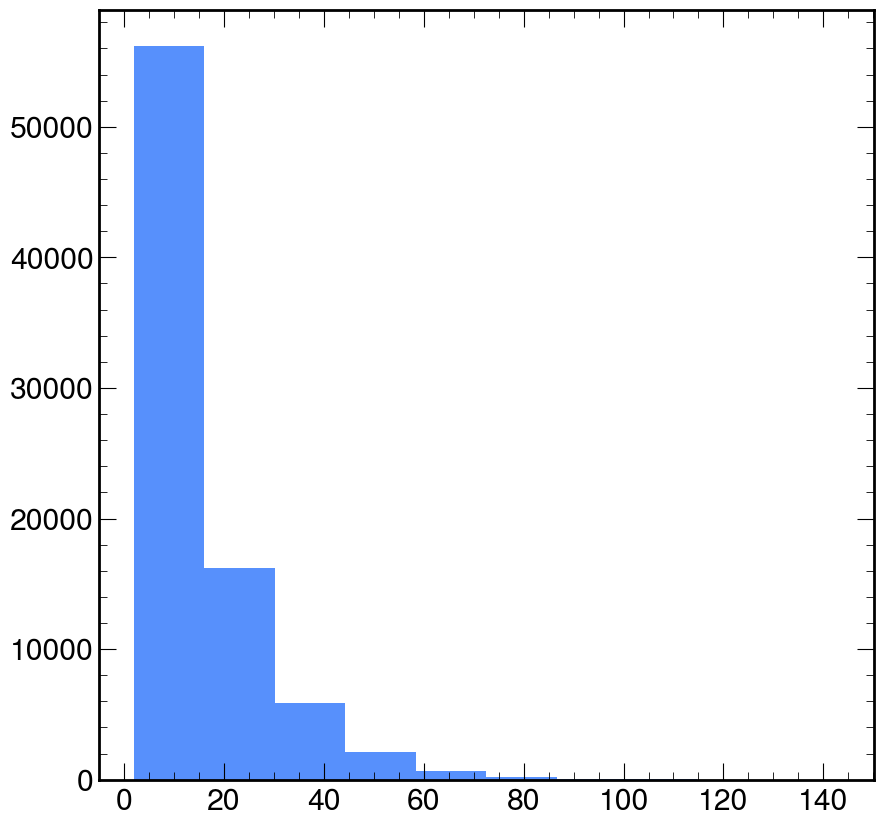

In [ ]:
plt.hist(ak.flatten(feats[:, :, 9]))